## OBJECTIVE'S - **understand control flow of ACTUATOR and CONTORL Interaction**

### Sub Tasks 
- setup: create *dm_control-leaning-worklog.ipynb*
- explore control: skim through actuator creation and contorl
- inspect model: load model in notebook, print joints and actuators, note differences
- porting notes: list what breaks when copying, what must change, what stays same
- proof delivery: update README with summary, record Loom walkthrough, commit changes

### Refered repos
- https://github.com/google-deepmind/dm_control/blob/04970f6b/README.md#L10-L33
- https://github.com/google-deepmind/mujoco/blob/b56cf98e/README.md#L17-L31
- https://github.com/DLR-RM/stable-baselines3/blob/dd7f5bfe/README.md#L10-L18

### Documentations Refered
- https://github.com/google-deepmind/dm_control/blob/main/dm_control/mujoco/tutorial.ipynb
- https://deepwiki.com/google-deepmind/dm_control
- https://deepwiki.com/google-deepmind/mujoco
- https://deepwiki.com/DLR-RM/stable-baselines3
- https://huggingface.co/lerobot/unitree-g1-mujoco/tree/a91de1dcd8f120ab96fd35a3f28f290d994348d7

#### Check if dm_contorl is correctly installed 

In [4]:
print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError('dn_contorl is not installed on the system!')
else:
  del suite, pixels
print('dm_control installation succeeded.')
     

Checking that the dm_control installation succeeded...
dm_control installation succeeded.


#### All `dm_control` imports required during trails/experiments

In [5]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer envrioments 
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite for ready made enviroments
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Manipulation
from dm_control import manipulation


#### Other necassory import

In [17]:
import numpy as np
from dm_control import mujoco
from dm_control import mujoco as dm_mujoco
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import PIL.Image

#### Example : Child body with a joint
XML-Constants

- mujoco : Root container for the entire simulation model.
- option : Global physics settings such as integration and solver parameters.
- gravity: 3D vector defining downward acceleration (e.g., 0 0 -9.81).
- worldbody : The static reference frame where all other bodies are anchored.
---
- body: A physical object container for mass, joints, and geometry.
- name: A unique string identifier for referencing the object in code.
- pos: The 3D coordinates (x,y,z) relative to the parent body's origin.
- euler: Orientation defined by three rotation angles around the X, Y, and Z axes.
---
- joint : Defines the specific degree of freedom/motion between bodies.
- type = "hinge": A joint type that allows rotation around a single defined axis.
- axis: The vector (e.g., 0 1 0) specifying the direction of joint rotation.
---
- geom: The physical shape used for collision detection and visual rendering.
- type: The geometric primitive shape, such as box or capsule.
- size: Dimensions of the shape (e.g., half-lengths for boxes).
- rgba: Color and opacity defined as Red, Green, Blue, and Alpha (0–1).
- fromto: Defines the specific start and end points for capsules or cylinders.
- mjVIS_JOINT: Visualization flag to render the joint's rotational axis.

#### Model-Defination in XML

In [45]:
# Example - A child body with a joint { vertical-output: true }

swinging_body = """
<mujoco>
  <option gravity="0 0 -9.81"/>
  <visual>
    <global offwidth="640" offheight="480"/>
  </visual>
  <asset>
    <texture name="skybox" type="skybox" builtin="gradient" rgb1=".6 .8 1" rgb2="2 1 1" width="800" height="800"/>
  </asset>
  <worldbody>
    <light directional="true" diffuse=".8 .8 .8" pos="0 0 10" dir="0 1 0"/>
    <body name="base" pos="0 0 0">
      <geom type="box" size="0.1 0.1 0.1" rgba="0.7 0.7 0.7 1"/>
      <body name="swing" pos="0 0 0.3" euler="0 0 90">
        <joint name="hinge" type="hinge" axis="0 1 0" pos="0 0 0"/>
        <geom type="capsule" fromto="0 0 0 0 0 0.3" size="0.05" rgba="0.2 0.5 0.8 1"/>
      </body>
    </body>
  </worldbody>

  <actuator>
    <motor name="swing_motor" joint="hinge" ctrlrange="-1 1" gear="50"/>
  </actuator>
</mujoco>
"""

#### Rendring the model with predfined enviroment

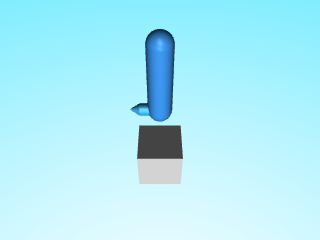

In [46]:
# Loading model
physics = mujoco.Physics.from_xml_string(swinging_body)

# Visualize the joint axis.
scene_option = mujoco.wrapper.core.MjvOption()
scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True

# Captures 2d rgb array for the current state and convert that into an immage
pixels = physics.render(scene_option=scene_option)
PIL.Image.fromarray(pixels)

#### List for Joint's and Actuator's 

In [47]:
# Print all Joints names and their IDs
for i in range(physics.model.njnt):
    # Print the joint's name
    joint_name = physics.model.id2name(i, 'joint')
    print(f"\nJoint ID {i}: {joint_name}")


Joint ID 0: hinge


In [48]:
# Print all Actuator names and their IDs
for i in range(physics.model.nu):
    actuator_name = physics.model.id2name(i, 'actuator')
    print(f"Actuator ID: {i} | Name: {actuator_name}")

Actuator ID: 0 | Name: swing_motor


#### Function to generate Video inside the notebook itself

In [49]:
def generate_video(physics, duration=2.0, framerate=30):
    """Simulates and returns an HTML5 video player.
        - has joint axis visulaizer enabled
        - 
    """

    scene_option = mujoco.wrapper.core.MjvOption()
    scene_option.flags[enums.mjtVisFlag.mjVIS_JOINT] = True
    
    frames = []
    physics.reset()
    # physics.data.qvel[0] = 5.0 # Gives the first joint a velocity of 5 rad/s
    while physics.data.time < duration:
        # Using sinosidal wav to contorl the joint actuator
        physics.data.ctrl[0] = np.sin(5.0 * physics.data.time)
        physics.step()
        if len(frames) < physics.data.time * framerate:
            pixels = physics.render(scene_option=scene_option)
            frames.append(pixels)

    # Minimal Animation logic
    fig, ax = plt.subplots(figsize=(frames[0].shape[1]/70, frames[0].shape[0]/70))
    ax.set_axis_off()
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    
    def update(frame):
        im.set_data(frame)
        return [im]
    
    anim = animation.FuncAnimation(fig, update, frames=frames, interval=1000/framerate, blit=True)
    plt.close() # Prevents static plot from showing
    return HTML(anim.to_html5_video())

physics = mujoco.Physics.from_xml_string(swinging_body)
generate_video(physics, duration=5.0)